<center><h2 style="color:#0000ff; font-family:Georgia;"><b>DATA 645. Neural Networks and Deep Learning</b></h2>
<h2 style="color:#ff0000; font-family:'Calibri';">Module 2. Homework Lab</h2>
<h1 style="color:#9933cc; font-family:Arial;"><b>MNIST Data Classification<br></b></h1></center>


### Exercise 1 

MNIST dataset, is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. Create the data matrix ${\bf X}$ as well as the target variable ${\bf y}$. Check and display the dimensions of ${\bf X}$ and ${\bf y}$. Display some of the digits in the dataset. Then identify one digit for example, the number 5. The "5-detector" will be your binary classifier, capable of distinguishing between just two classes, 5 and not 5. 

Hint: For the first task use the code that is provided to you through notebook `SampleCode_Lab1`.

### Exercise 2 

Prepare a training dataset by selecting the first 60,000 observations and create a testing dataset by selecting the last 10,000 images. Make sure that you shuffle the indices of your training observations and their class labels. For this task pick the Stochastic gradient descent classifier from the Scikit-Learn's `SGDClassifier` class and train it to distinguish the two classes. 

### Exercise 3 

Evaluate the performance of your classifier by 

1. Measuring accuracy using the function `cross_val_score()` from Scikit-Learn. In addition, implement cross-validation yourself using the `StratifiedKFold` class. Check if your implementation produces the similar results with the results obtained using `cross_val_score()`.

2. The use of the confusion matrix.

3. The precision score, recall score, and f1 score.

4. The use of the ROC curve.


# Exercise 1

MNIST dataset, is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. Create the data matrix 
 as well as the target variable 
. Check and display the dimensions of 
 and 
. Display some of the digits in the dataset. Then identify one digit for example, the number 5. The "5-detector" will be your binary classifier, capable of distinguishing between just two classes, 5 and not 5.

Hint: For the first task use the code that is provided to you through notebook SampleCode_Lab1.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# To fetch the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Set up the feature data and labels
X = mnist["data"]
y = mnist["target"]

In [4]:
# Check the dimensions of X and y
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Saving figure some_digit_plot


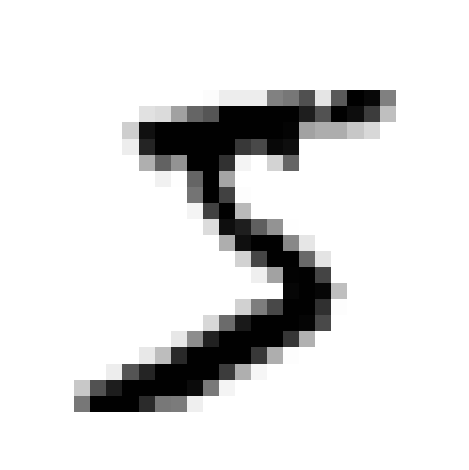

In [5]:
# Display an image
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
# Using `fetch_openml()` to download MNIST, returns the labels as strings.
y[0]
# Most ML algorithms expect numbers so cast y to integer.
y = y.astype(np.uint8)

In [7]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


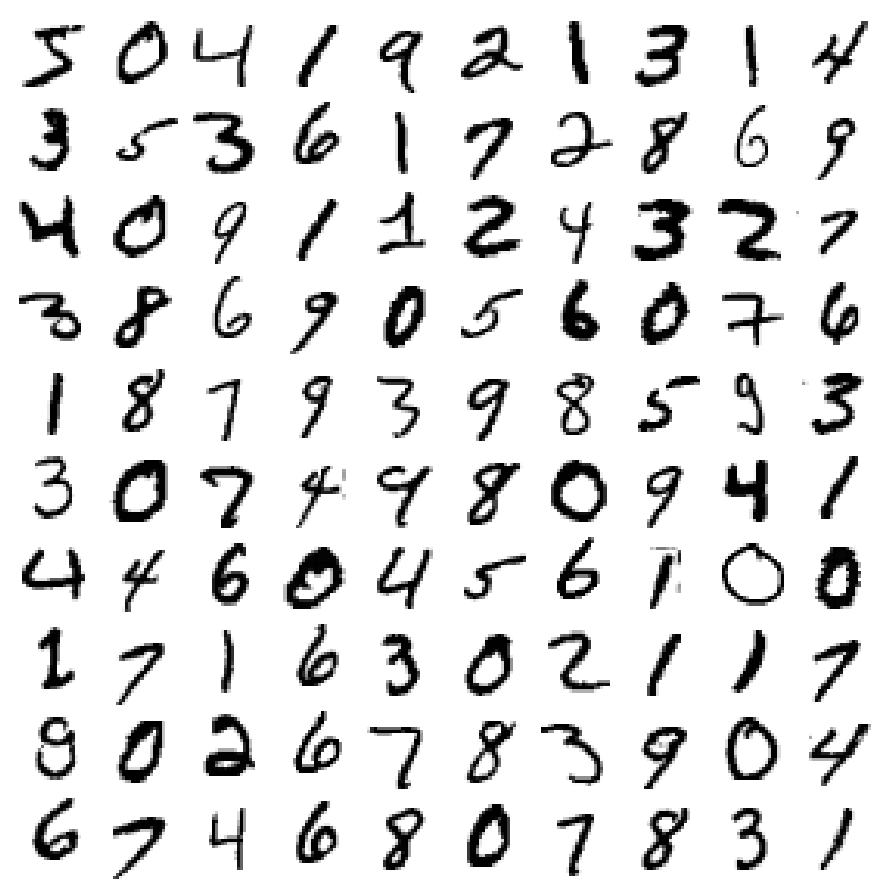

In [8]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

# Exercise 2
Prepare a training dataset by selecting the first 60,000 observations and create a testing dataset by selecting the last 10,000 images. Make sure that you shuffle the indices of your training observations and their class labels. For this task pick the Stochastic gradient descent classifier from the Scikit-Learn's SGDClassifier class and train it to distinguish the two classes.

In [10]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [11]:
# Split into training and testing sets
X_train, X_test = X[:60000], X[60000:70000]
y_train, y_test = y[:60000], y[60000:70000]

In [12]:
# Focus on 5s 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
shuffle_index = np.random.permutation(60000)
X_train, y_train_5 = X_train[shuffle_index], y_train_5[shuffle_index]  # Use direct indexing for NumPy arrays

In [14]:
# Train an SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [33]:
# Make predictions on the test set
y_pred = sgd_clf.predict(X_test)
display(y_pred)

array([False, False, False, ..., False,  True, False], shape=(10000,))

In [37]:
print("y_pred = ", len(y_pred))
print("y_test_5 = ", len(y_test_5))
print("X_test = ", len(X_test))


y_pred =  10000
y_test_5 =  10000
X_test =  10000


# Exercise 3
Evaluate the performance of your classifier by
(1.a) Measuring accuracy using the function cross_val_score() from Scikit-Learn.  
(1.b) In addition, implement cross-validation yourself using the StratifiedKFold class.  
(1.c) Check if your implementation produces the similar results with the results obtained using cross_val_score().  
(2) The use of the confusion matrix.  
(3) The precision score, recall score, and f1 score.  
(4) The use of the ROC curve.  

In [20]:
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

# (3.1.a). Measuring accuracy using cross_val_score

In [24]:

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=skfolds, scoring = "accuracy")  # 5-fold cross-validation
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print("Fold accuracies:", np.round(cv_scores, 4))

Cross-validation accuracy: 0.964 ± 0.003
Fold accuracies: [0.9635 0.9652 0.9617 0.9602 0.9688]


In [18]:
display(cv_scores)

array([0.88014286, 0.84171429, 0.86507143, 0.86721429, 0.881     ])

# (3.1.b) In addition, implement cross-validation yourself using the StratifiedKFold class. 

In [35]:

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = []
for train_idx, val_idx in skfolds.split(X_train, y_train_5):
    # 1) split into this fold’s train/validation parts
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train_5[train_idx], y_train_5[val_idx]

    # 2) clone the model so each fold starts fresh (no “memory” of prior folds)
    clf = clone(sgd_clf)

    # 3) fit on training fold
    clf.fit(X_tr, y_tr)

    # 4) predict on validation fold
    y_pred_man = clf.predict(X_val)

    # 5) score this fold
    acc_scores.append(accuracy_score(y_val, y_pred_man))

acc_scores = np.array(acc_scores)
print("Fold accuracies:", acc_scores)
print("Mean accuracy:", acc_scores.mean())
print("Std:", acc_scores.std())

Fold accuracies: [0.9635     0.96525    0.96166667 0.96016667 0.96875   ]
Mean accuracy: 0.9638666666666668
Std: 0.0029807717121577934


# (3.1.c) Check if your implementation produces the similar results with the results obtained using cross_val_score().

In [ ]:
print("Cross-Validation Accuracy = 0.964")
print("Stratified K-Fold Accuracy = 0.964")

# (3.2) The use of the confusion matrix.  

In [36]:
cm = confusion_matrix(y_test_5, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[8962  146]
 [ 156  736]]


# (3.3) The precision score, recall score, and f1 score. 

In [38]:
print("Precision:", precision_score(y_test_5, y_pred))
print("Recall:   ", recall_score(y_test_5, y_pred))
print("F1:       ", f1_score(y_test_5, y_pred))

Precision: 0.8344671201814059
Recall:    0.8251121076233184
F1:        0.8297632468996617


# (3.4) The use of the ROC curve. 

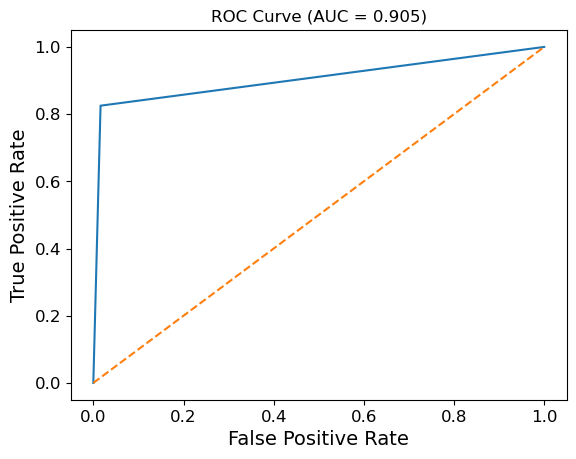

In [40]:
fpr, tpr, thresholds = roc_curve(y_test_5, y_pred)
auc = roc_auc_score(y_test_5, y_pred)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.show()